In [4]:
import os
import numpy as np
import ast
import pandas as pd
from scipy.ndimage import uniform_filter1d 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from collections import Counter
from tqdm import tqdm
sns.set_theme(style="white")
plt.figure(figsize=(10, 8))
colors = ['#66c2a5', '#fc8d62']


plt.rcParams.update({
    'font.size': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 30,
    'axes.titlesize': 30
})

task = "aime24"
models = ["qwen3-32b", "qwen3-14b","qwen3-8b","qwen3-4b","qwen3-1-7b", "qwen3-0-6b"]

<Figure size 1000x800 with 0 Axes>

In [5]:
sparse_method = "topk"
if sparse_method == "topk":
    fname_sign = """_local0_topk{budget}"""
elif sparse_method == "blocktopk":
    fname_sign = """_local0_block{block_size}_blocktopk{block_topk}"""
else:
    raise ValueError(f"Invalid sparse method: {sparse_method}")

In [8]:
max_cost = 4e4
min_cost= 45
cost_points = np.logspace(np.log10(min_cost), np.log10(max_cost), 100)

sparse_points = []
dense_points = []

root_dir = "/home/rsadhukh/ranajoy/sparse_scaling/cost_model/zhuoming"

for model in models:
    if os.path.exists(f"{root_dir}/{task}/dense/{task}_{model}_dense_numTrials_tradeoff_B200"):
        dense_df = pd.read_csv(f"{root_dir}/{task}/dense/{task}_{model}_dense_numTrials_tradeoff_B200")
    else:
        dense_df = None
    
    sparse_df = []
    for budget in [128, 256, 512, 1024, 2048]:
        block_size = 16384 // budget
        block_topk = budget // block_size
        
        if sparse_method == "topk":
            fname = f"{root_dir}/{task}/{sparse_method}/{task}_{model}{fname_sign.format(budget=budget)}_numTrials_tradeoff_B200.csv"
        elif sparse_method == "blocktopk":
            fname = f"{root_dir}/{task}/{sparse_method}/{task}_{model}{fname_sign.format(block_size=block_size, block_topk=block_topk)}_numTrials_tradeoff_B200.csv"
        else:
            raise ValueError(f"Invalid sparse method: {sparse_method}")
        
        if os.path.exists(fname):
            sparse_df.append(pd.read_csv(fname))
    if len(sparse_df) > 0:
        sparse_df = pd.concat(sparse_df)
    else:
        sparse_df = None
    
    covs = []
    if dense_df is not None:
        for i, cost in enumerate(cost_points):
            best_covs = []
            for query_id in dense_df["query_id"].unique():
                query_df = dense_df[dense_df["query_id"] == query_id]
                best_coverage = query_df[query_df["total_cost"] <= cost]["coverage"]
                if len(best_coverage) > 0:
                    best_cov = best_coverage.max()
                    best_covs.append(best_cov)
                else:
                    best_covs.append(0)
            covs.append(np.mean(best_covs))
        
        dense_points.append((model, "full", covs, cost_points))
        
    sparse_covs = []
    if sparse_df is not None:
        for i, cost in enumerate(cost_points):
            best_covs = []
            best_ntrials = []
            best_budgets = []
            median_generation_lengths = []
            for query_id in sparse_df["query_id"].unique():
                query_df = sparse_df[sparse_df["query_id"] == query_id]
                best_coverage = query_df[query_df["total_cost"] <= cost]["coverage"]
                if len(best_coverage) > 0:
                    cur_best_cov = best_coverage.max()
                    best_covs.append(cur_best_cov)
                else:
                    best_covs.append(0)
            sparse_covs.append(np.mean(best_covs))
        sparse_points.append((model, "sparse", sparse_covs, cost_points))
        

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import inferno
from matplotlib.colors import Normalize

import matplotlib.colors as mcolors

def get_shades(base_color, n_shades=6, darken_factor=0.4):
    """Return n_shades darker shades of the base_color."""
    base_rgb = np.array(mcolors.to_rgb(base_color))
    dark_rgb = base_rgb * darken_factor  # darker version
    shades = [mcolors.to_hex((1 - alpha) * base_rgb + alpha * dark_rgb)
              for alpha in np.linspace(0, 1, n_shades)]
    return shades

shades_dense = get_shades(colors[1], n_shades=len(models))
shades_sparse = get_shades(colors[0], n_shades=len(models)) 

# Example data
c = np.linspace(0, 1, 100)  # Values to map to colors
covs = np.sin(2 * np.pi * c)  # Example y-values

# Normalize the values for the colormap
norm = Normalize(vmin=min(c), vmax=max(c))

# Generate colors using the inferno colormap
colors = inferno(norm(c)) 
print(len(colors)) 

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import plasma 
from matplotlib.colors import Normalize

# Example data
c = np.linspace(0, 1, 100)  # Values to map to colors
covs = np.sin(2 * np.pi * c)  # Example y-values

# Normalize the values for the colormap
norm = Normalize(vmin=min(c), vmax=max(c))

# Generate colors using the cividis colormap
colors2 = plasma(norm(c)) # Dark Blue (#00008B), Blue (#1E90FF), Light Blue (#00CED1), Blue-Green (#008B8B), Green (#008000). 
colors2 = ["#00008B", "#1E90FF", "#00CED1", "#008B8B", "#008000", "#4169E1"] 
# colors2 = ["#008000"] 
colors2 = colors2[: : -1] 

colors = sns.color_palette("rocket", n_colors=6) 
colors2 = sns.color_palette("mako", n_colors = 6) 

100


6
6
[0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 2.03, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 4.02, 32.76, 32.76, 32.76, 32.76, 32.76, 32.76, 32.76, 32.76, 32.76, 32.76, 32.76, 32.76]
[0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 4.02, 4.02, 4.02, 4.02, 4.02, 14.33

<Figure size 640x480 with 0 Axes>

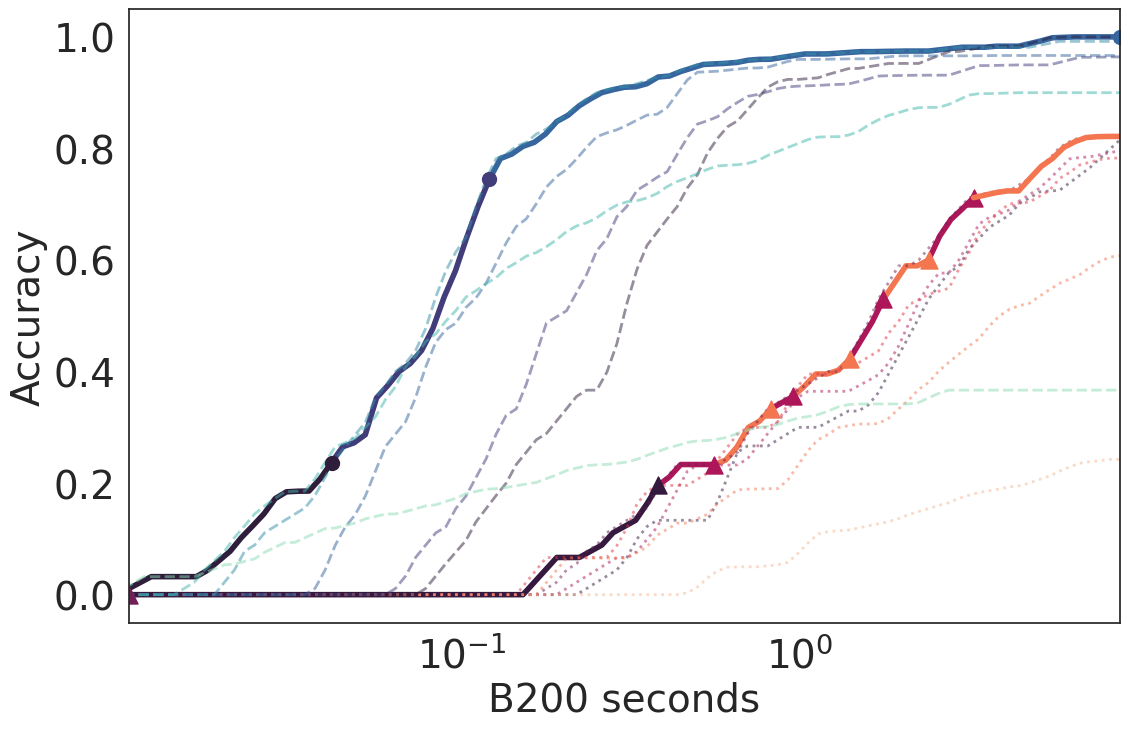

In [10]:
plt.clf() 

window_size = 3 

plt.figure(figsize=(12, 8))
# sns.set_theme(style="whitegrid")
all_dense_points = []
# for i, ((model, label, covs, cost_points), color) in enumerate(zip(dense_points, shades_dense)) 
print(len(dense_points)) 
for i, ((model, label, covs, cost_points), color) in enumerate(zip(dense_points, shades_dense)): 
    c = np.array(cost_points) / 4500 
    smooth_covs = uniform_filter1d(covs, window_size) 
    plt.plot(c, smooth_covs, linestyle=":", linewidth=2,alpha=0.5, color=colors[i]) 
    all_dense_points += [(model, p[0], p[1]) for p in zip(smooth_covs, cost_points)]

all_sparse_points = []
# for (model, budget, covs, cost_points), color in zip(sparse_points, shades_sparse): 
print(len(sparse_points)) 
for i, ((model, budget, covs, cost_points), color) in enumerate(zip(sparse_points, shades_sparse)): 
    c = np.array(cost_points) / 4500 
    smooth_covs = uniform_filter1d(covs, window_size) 
    plt.plot(c, smooth_covs, linestyle="--", linewidth=2,alpha=0.5, color = colors2[i]) 
    all_sparse_points += [(model, p[0], p[1]) for p in zip(smooth_covs, cost_points)] 


model_sizes = {
    "qwen3-32b": 32.76,
    "qwen3-8b": 8.19,
    "qwen3-4b": 4.02,
    "qwen3-14b": 14.33,
    "qwen3-1-7b": 2.03,
    "qwen3-0-6b": 0.752
} 

model_sizesinverse = {
    v: k for k, v in model_sizes.items() 
} 

models2 = ["qwen3-32b", "qwen3-14b","qwen3-8b","qwen3-4b","qwen3-1-7b", "qwen3-0-6b"] 
models2 = models2[: : -1] 


all_sparse_points = sorted(all_sparse_points, key=lambda x: x[0])
all_dense_points = sorted(all_dense_points, key=lambda x: x[0])
all_costs = [p[2] for p in all_sparse_points]
best_model_sizes = [] 
best_model_sizesdense = [] 
best_sparse_acc = []
best_dense_acc = []
max_cost = 4e4
min_cost= 20
cost_points = np.logspace(np.log10(min_cost), np.log10(max_cost), 100)
x_data = []
y_data = []
for c in cost_points:
    valid_points = [p for p in all_sparse_points if  p[2] <= c] 
    if not valid_points:
        best_model_sizes.append(0.752) 
        continue
    best_point = max(valid_points, key=lambda x: x[1])
    best_sparse_acc.append(best_point[1])
    best_model_sizes.append(model_sizes[best_point[0]])
    x_data.append(c) 
print(best_model_sizes) 

for c in cost_points:
    valid_points = [p for p in all_dense_points if  p[2] <= c]
    if not valid_points: 
        best_model_sizesdense.append(0.752) 
        continue
    best_point = max(valid_points, key=lambda x: x[1])
    best_dense_acc.append(best_point[1]) 
    best_model_sizesdense.append(model_sizes[best_point[0]]) 
    y_data.append(c) 
print(best_model_sizesdense) 

x_data = np.array(x_data) / 4500
y_data = np.array(y_data) / 4500 
print(len(x_data), len(y_data), len(best_sparse_acc), len(best_dense_acc)) 
colorsspecial = [] 
# colors2 = [] 

last_best_model = 0.752 
last_startidx = 0 
for i in range(len(x_data)): 
    if best_model_sizes[i] != last_best_model: 
        plt.plot(x_data[last_startidx : i + 1], best_sparse_acc[last_startidx : i + 1], color = colors2[models2.index(model_sizesinverse[last_best_model])], linewidth=4, zorder = 1) 
        plt.scatter(x_data[i], best_sparse_acc[i], color = colors2[models2.index(model_sizesinverse[last_best_model])], s=100, zorder = 2) 
        last_best_model = best_model_sizes[i] 
        last_startidx = i 
    else: 
        continue 
plt.plot(x_data[last_startidx : ], best_sparse_acc[last_startidx : ], color = colors2[models2.index(model_sizesinverse[last_best_model])], linewidth=4) 
# plt.scatter(x_data, best_sparse_acc, label=f"Pareto Frontier (Topk)", c = colorsspecial) 
last_best_model = 2.03 
last_startidx = 0 
for i in range(len(x_data)): 
    if best_model_sizesdense[i] != last_best_model: 
        plt.plot(y_data[last_startidx : i + 1], best_dense_acc[last_startidx : i + 1], color = colors[models2.index(model_sizesinverse[last_best_model])], linewidth=4, zorder = 1) 
        plt.scatter(y_data[i], best_dense_acc[i], color = colors[models2.index(model_sizesinverse[last_best_model])], s = 150, marker = '^', zorder = 2) 
        last_best_model = best_model_sizesdense[i] 
        last_startidx = i 
    else: 
        continue 
plt.plot(y_data[last_startidx : ], best_dense_acc[last_startidx : ], color = colors[models2.index(model_sizesinverse[last_best_model])], linewidth=4) 
# plt.plot(y_data, best_dense_acc, label=f"Pareto Frontier (Dense)", linewidth=4, color=colors[1]) 

t_thresh = 0.5
acc_thresh = 0.7

x_data_acc_diff = [i for i, p in enumerate(x_data) if p <= 0.5][-1]
sparse_acc_08 = best_sparse_acc[x_data_acc_diff]
dense_acc_08 = best_dense_acc[x_data_acc_diff]

y_data_time_diff = [i for i, p in enumerate(best_sparse_acc) if p <=0.6][-1]
sparse_time_08 = y_data[y_data_time_diff]
x_data_time_diff = [i for i, p in enumerate(best_dense_acc) if p <=0.6][-1]
dense_time_08 = x_data[x_data_time_diff] 

# plt.annotate(
#     '', 
#     xy=(x_data[x_data_acc_diff], best_sparse_acc[x_data_acc_diff]),  
#     xytext=(y_data[x_data_acc_diff], best_dense_acc[x_data_acc_diff]),
#     arrowprops=dict(arrowstyle='<->', linewidth=4, color='gray')
# )

# plt.annotate(
#     '', 
#     xy=(sparse_time_08, 0.6),  
#     xytext=(dense_time_08, 0.6),
#     arrowprops=dict(arrowstyle='<->', linewidth=4, color='gray')
# )

# plt.text(x_data[x_data_acc_diff], 
#          (best_sparse_acc[x_data_acc_diff] + best_dense_acc[x_data_acc_diff])/2, 
#          f"{(sparse_acc_08 - dense_acc_08)*100:.1f}", 
#          ha='left', va='top', fontsize=26, color='gray')

# plt.text((sparse_time_08 + dense_time_08)/2, 
#          0.6, 
#          f"{dense_time_08/sparse_time_08:.1f} X", 
#          ha='center', va='bottom', fontsize=26, color='gray')

plt.xscale("log")

plt.xlabel("B200 seconds", fontsize=28)
plt.ylabel("Accuracy", fontsize=28)

# plt.legend(loc='upper left', fontsize=23) 
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
# plt.xlim(0.01, 11)
plt.xlim(x_data[0], x_data[-1])
plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.1)
plt.tight_layout()
ax = plt.gca() 

# for spine in ax.spines.values():
#     spine.set_visible(False) 

plt.savefig(f"{task}_acc_vs_trials_topk.pdf") 


In [4]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm

def get_shades(base_color, n_shades=6, darken_factor=0.4):
    """Return n_shades darker shades of the base_color."""
    base_rgb = np.array(mcolors.to_rgb(base_color))
    dark_rgb = base_rgb * darken_factor  # darker version
    shades = [mcolors.to_hex((1 - alpha) * base_rgb + alpha * dark_rgb)
              for alpha in np.linspace(0, 1, n_shades)]
    return shades

shades_dense = get_shades(colors[1], n_shades=len(models))
shades_sparse = get_shades(colors[0], n_shades=len(models))
shades_sparse = shades_sparse[::-1]
shades_dense = shades_dense[::-1]


In [ ]:
from scipy.ndimage import uniform_filter1d

plt.clf()

fig, ax = plt.subplots(figsize=(12, 8))

model_sizes = {
    "qwen3-32b": 32.76,
    "qwen3-8b": 8.19,
    "qwen3-4b": 4.02,
    "qwen3-14b": 14.33,
    "qwen3-1-7b": 2.03,
    "qwen3-0-6b": 0.752
}

window_size = 3

all_dense_points = []
for (model, label, covs, cost_points), color in zip(dense_points, shades_dense):
    c = np.array(cost_points) / 4500
    smooth_covs = uniform_filter1d(covs, window_size)
    plt.plot(c, smooth_covs, linestyle="-", linewidth=2,alpha=0.5, color=color)
    all_dense_points += [(model, p[0], p[1]) for p in zip(smooth_covs, cost_points)]

all_sparse_points = []
for (model, budget, covs, cost_points), color in zip(sparse_points, shades_sparse):
    c = np.array(cost_points) / 4500
    smooth_covs = uniform_filter1d(covs, window_size)
    plt.plot(c, smooth_covs, linestyle="--", linewidth=2,alpha=0.5, color=color)
    all_sparse_points += [(model, p[0], p[1]) for p in zip(smooth_covs, cost_points)]

all_sparse_points = sorted(all_sparse_points, key=lambda x: x[0])
all_dense_points = sorted(all_dense_points, key=lambda x: x[0])
all_costs = [p[2] for p in all_sparse_points]
best_model_sizes = []
best_sparse_acc = []
best_dense_acc = []
max_cost = 4e4
min_cost= 20
cost_points = np.logspace(np.log10(min_cost), np.log10(max_cost), 100)
x_data = []
y_data = []
for c in cost_points:
    valid_points = [p for p in all_sparse_points if  p[2] <= c]
    if not valid_points:
        best_model_sizes.append(None)
        continue
    best_point = max(valid_points, key=lambda x: x[1])
    best_sparse_acc.append(best_point[1])
    best_model_sizes.append(model_sizes[best_point[0]])
    x_data.append(c)

for c in cost_points:
    valid_points = [p for p in all_dense_points if  p[2] <= c]
    if not valid_points:
        continue
    best_point = max(valid_points, key=lambda x: x[1])
    best_dense_acc.append(best_point[1])
    y_data.append(c)

x_data = np.array(x_data) / 4500
y_data = np.array(y_data) / 4500
plt.plot(x_data, best_sparse_acc, label=f"Pareto Frontier (Topk)", linewidth=4, color=colors[0])
plt.plot(y_data, best_dense_acc, label=f"Pareto Frontier (Dense)", linewidth=4, color=colors[1])

t_thresh = 0.5
acc_thresh = 0.8

x_data_acc_diff = [i for i, p in enumerate(x_data) if p <= t_thresh][-1]
sparse_acc_08 = best_sparse_acc[x_data_acc_diff]
dense_acc_08 = best_dense_acc[x_data_acc_diff]

y_data_time_diff = [i for i, p in enumerate(best_sparse_acc) if p <=acc_thresh][-1]
sparse_time_08 = y_data[y_data_time_diff]
x_data_time_diff = [i for i, p in enumerate(best_dense_acc) if p <=acc_thresh][-1]
dense_time_08 = x_data[x_data_time_diff]

plt.annotate(
    '', 
    xy=(x_data[x_data_acc_diff], best_sparse_acc[x_data_acc_diff]),  
    xytext=(y_data[x_data_acc_diff], best_dense_acc[x_data_acc_diff]),
    arrowprops=dict(arrowstyle='<->', linewidth=4, color='gray')
)

plt.annotate(
    '', 
    xy=(sparse_time_08, acc_thresh),  
    xytext=(dense_time_08, acc_thresh),
    arrowprops=dict(arrowstyle='<->', linewidth=4, color='gray')
)

plt.text(x_data[x_data_acc_diff], 
         (best_sparse_acc[x_data_acc_diff] + best_dense_acc[x_data_acc_diff])/2, 
         f"{(sparse_acc_08 - dense_acc_08)*100:.1f}", 
         ha='left', va='top', fontsize=26, color='gray')

plt.text((sparse_time_08 + dense_time_08)/2, 
         acc_thresh, 
         f"{dense_time_08/sparse_time_08:.1f} X", 
         ha='center', va='bottom', fontsize=26, color='gray')

plt.xscale("log")

plt.xlabel("B200 seconds", fontsize=28)
plt.ylabel("Accuracy", fontsize=28)

plt.legend(loc='upper left', fontsize=23)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlim(0.01, 11)
plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.1)
plt.tight_layout()
ax = plt.gca()

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig(f"{task}_acc_vs_trials_topk.pdf")